# Bodyscan engine
This notebook provides the training platform for the body shape parameter estimation from single Kinect depth image.

Updated by Jack Z., Quintuple Software, 2020/03/16.

Installs packages needed from the local mirror server for the first run.

In [1]:
mirror_path = "-i https://pypi.tuna.tsinghua.edu.cn/simple/ --trusted-host pypi.tuna.tsinghua.edu.cn --default-timeout=1000"
#!pip install tensorflow-gpu {mirror_path}
#!pip install matplotlib {mirror_path}
#!pip install pandas {mirror_path}
#!pip install sklearn {mirror_path}
#!pip install Pillow {mirror_path}
#!pip install tensorboard {mirror_path}
#!pip install packaging

Imports libraries and check the tensorflow version.

Note that you need tf 2.0 or above to train the dataset, but you also need tf 1.14 for converting the model to pb file to use it on C++.

> Make certain modification for the conversion purpose, such as loading the keras model instead of building it, and running the cell that converting SaveModel into pb format.

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

from packaging import version

print(tf.__version__)

is_tf2 = version.parse(tf.__version__).release[0] >= 2
assert is_tf2, "This notebook requires TensorFlow 2.0 or above."

2.1.0


In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Loads and pre-processing dataset

Loads image file names into `file_metas`.

In [4]:
import os, fnmatch

def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result


files = find('*_front.png', './dataset/man_depth/')

print('Number of images: ', len(files))

Number of images:  15170


In [5]:
def extract_file_meta(file):
    idx = file.rfind('/')
    idx2 = file.find('.obj')
    sub = file[idx+1:idx2+4]
    return file, sub

file_metas = [extract_file_meta(f) for f in files]  # list of (full path, model name)
#display(file_metas)

Loads 3d model shape parameter information into `value_map`.

In [6]:
import pandas as pd
# load file
value_df = pd.read_csv('./dataset/man_data.csv')
value_map = {}
for row in value_df.to_numpy():
    name = row[0]
    values = row[1:]
    value_map[name] = values

print('Number of humans: ', len(value_map))  # dic(model name) -> 48 parameters
param_names = list(value_df.columns.values)

Number of humans:  1517


Couple the image file name and it's values (`dataset`, `values`)

In [7]:
dataset = []
values = []
for m in file_metas:
    dataset.append(m[0])
    obj = m[1]
    val = value_map[obj]
    values.append(np.array(val))
values = np.array(values)
display('size of dataset', len(dataset))
display('dimension of values', values.shape)

'size of dataset'

15170

'dimension of values'

(15170, 24)

Loads input images into `input_ds`.
For the consideration of memory limit, we use random `total_img_count`(15k) images.

Input images will be normalized into the range of 1.2m ~ 2.9m, with the depth resolution of 1mm.

In [8]:
import numpy as np
from sklearn.utils import shuffle

total_img_count = 10000
dataset_sf, values_sf = shuffle(dataset, values)

dataset_sf = dataset_sf[:total_img_count]
values_sf = values_sf[:total_img_count]

total_img_count = len(dataset_sf)

Set `is_load` to false for the first run, and to true for the continuous use for the performance.

It needs approx 8GB of RAM for 15k dataset.

In [9]:
from PIL import Image
    
min_depth = 1200  # 1900
max_depth = 2900  # 3700

def load_img(file_path, n_channels=1, verbose=False):
    global img_count, total_img_count
    img_count = img_count + 1
    if img_count % 100 == 0:
        print ('.', end='')
    if img_count % 1000 == 0:
        print('{}/{}'.format(img_count, total_img_count))    

    im = Image.open(file_path)  # read image using matplotlib
    im.load()
    if verbose:
        display(np.histogram(np.array(im), bins=100))
    im = (np.array(im) * 5000 // 65535).astype(dtype=np.int16)
    #im[np.where(im==0)] = 5000
    #im = resize(im, (224,224), anti_aliasing=True)  # resize image using skimage
    # clip from min_depth~max_depth mm, which is the range where the body scan collapse.
    im = np.clip(im, min_depth, max_depth)
    im = (im - min_depth) * 1.0 / (max_depth - min_depth)
    if n_channels == 1:
        return im.astype(dtype=np.float16).reshape((512,512,1))
    else:
        return im.astype(dtype=np.float16).reshape((512,512,4))[:,:,0].reshape((512,512,1))

In [10]:
is_load = False
if is_load:
    input_ds = np.load('depth_array_.npy')
else:
    img_count = 0
    input_ds = np.array([load_img(file) for file in dataset_sf])
    np.save('depth_array_.npy', input_ds)
    print('Saved the pack.')
display('dimension of input_ds', input_ds.shape)

..........1000/10000
..........2000/10000
..........3000/10000
..........4000/10000
..........5000/10000
..........6000/10000
..........7000/10000
..........8000/10000
..........9000/10000
..........10000/10000
Saved the pack.


'dimension of input_ds'

(10000, 512, 512, 1)

Check if normalization is working alright.

In [11]:
#display(input_ds[0].reshape(-1, 4).tolist())
#np.save('depth_array.npy', input_ds)
display(np.histogram(input_ds[:100], bins=100))
#np.max(input_ds[0])

(array([24631803,        0,        0,        0,        0,        0,
               0,        0,        0,        0,        0,        0,
               0,        0,        0,       10,      296,      537,
             828,     1201,     3263,     2792,     4297,     6412,
           10393,    10972,    10603,     8441,     6981,     5964,
            7918,    11632,    15475,    19879,    20664,    19880,
           18093,    21775,    20904,    24108,    22730,    23308,
           25865,    29907,    34241,    32055,    34830,    34223,
           35723,    31969,    34461,    31760,    32675,    32927,
           29042,    30875,    31270,    26693,    25000,    26665,
           27339,    31516,    27333,    26863,    27368,    26980,
           29284,    33389,    31109,    28437,    33501,    32300,
           33285,    27710,    25851,    23337,    23022,    24320,
           22471,    21526,    20161,    22640,    21276,    18927,
           17671,    15301,    12187,    10074, 

Okay, now we split the whole dataset into training, validation and test.

In [11]:
sf_X, sf_y = input_ds, values_sf  # shuffle(input_ds, values_sf) #

def split(X, y, ratio=0.8):
    mid = int(ratio*X.shape[0])
    train_X = X[:mid]
    train_y = y[:mid]
    test_X = X[mid:]
    test_y = y[mid:]
    return (train_X, train_y), (test_X, test_y)

(known_X, known_y), (test_X, test_y) = split(sf_X, sf_y, 0.8)
(train_X, train_y), (validation_X, validation_y) = split(known_X, known_y, 0.8)

display('dimension of train_X', train_X.shape)
display('dimension of test_y', train_y.shape)

assert train_X.shape[0] == train_y.shape[0], "the number of samples should match for the input and output"

'dimension of train_X'

(6400, 512, 512, 1)

'dimension of test_y'

(6400, 24)

### Normalize the data

In [12]:
from sklearn.preprocessing import MinMaxScaler

normalize_on = False
if normalize_on:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(known_y)

    normalized_train_y = scaler.transform(train_y)
    normalized_validation_y = scaler.transform(validation_y)
    normalized_test_y = scaler.transform(test_y)
else:
    normalized_train_y = train_y.astype(dtype=np.float64)
    normalized_validation_y = validation_y.astype(dtype=np.float64)
    normalized_test_y = test_y.astype(dtype=np.float64)
    
assert normalized_train_y.dtype == np.float64, 'should be in the format of float64 to provide into tf tensor'

## Build the model and train the dataset

### Prepares tensorboard

Only use this section when you need to monitor the training progress with tensorflow, which will be only needed for the fine tuning hyper-parameters.

Loads tensorboard module.

In [13]:
%reload_ext tensorboard

Removes tensorboard cache.
  > Change the path of local user directory.

In [14]:
# remove all files here: C:\Users\jakezira\AppData\Local\Temp\.tensorboard-info
!rmdir /s /q "C:\\Users\\jakezira\\AppData\\Local\\Temp\\.tensorboard-info"

In [27]:
!rmdir /s /q "logs\\scalars"

The directory is not empty.


Starts tensorboard service. It timeouts when you try this on windows, but it's okay. Following cells shows the tensorboard anyway.

In [15]:
%tensorboard --logdir "logs/scalars"

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 18948.

Use following command on windows when you have conflicted app on windows.

In [22]:
 !TaskKill /PID 21888 /F

ERROR: The process "21888" not found.


When it stuck on timeout for the tensorboard starting, use following to open it here.
Or open here to see it on another browser: http://localhost:6006/#scalars

In [23]:
from tensorboard import notebook

notebook.list() # View open TensorBoard instances

notebook.display(port=6006, height=0)

Known TensorBoard instances:
  - port 6006: logdir logs/scalars (started 1:17:17 ago; pid 32316)


### Build the model

#### Prepares the tensorboard functionalities

In [38]:
import io
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

Clears the tensorflow workspace to free the GPU memory.

In [82]:
from datetime import datetime
from tensorflow.keras import backend as K

K.clear_session()

# Select GPU for the training
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[:], 'GPU')
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPU


Modifies `param` to define the *learning rate* curve.

In [83]:
param_exp = {
    'lr': 1.25*1e-2,
    'ds': 30,  # 25-> 30
    'dr': 1.4,  # 1.6 -> 1.4
    'mode': 'exp'
}

param_inv = {
    'lr': 1e-2,  # 1e-3 -> 1e-2
    'ds': 30,  # 20->30->25
    'dr': 1,  # 10->3->1
    'mode': 'inv'
}

param = param_exp

lr = param['lr']
ds = param['ds']
dr = param['dr']
mode = param['mode']

dt_str = datetime.now().strftime("%Y%m%d_%H%M%S")
logdir = "logs\\scalars\\" + dt_str + "_" + mode
file_writer = tf.summary.create_file_writer(logdir + "\\metrics")
file_writer.set_as_default()


def lr_schedule_exp(epoch):
    import math
    """
    Returns a custom learning rate that decreases as epochs progress.
    """
    learning_rate = 2*lr / (1 + math.pow(dr, (epoch // ds)))
    
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

def lr_schedule_invtime(epoch):
    import math
    """
    Returns a custom learning rate that decreases as epochs progress.
    Same as InverseTimeDecay.
    """
    learning_rate = lr / (1 + dr * (epoch // ds))

    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

if mode == 'inv':
    lr_schedule = lr_schedule_invtime
else:
    lr_schedule = lr_schedule_exp
lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,
                                                  histogram_freq=1,
                                                  profile_batch = 100000000)

Defines the tensorboard monitoring callback, including feature accuracy and outliers.

Comment out these callbacks when you don't use tensorboard.

In [84]:
def image_error(predictions):
    """Return a 5x5 grid of the MNIST images as a matplotlib figure."""
    # Use the model to predict the values from the validation dataset.
    n_features = 24
    feature_vals = np.array([np.absolute(test_y[:, i] - predictions[:,i]) for i in range(n_features)])
    feature_means = np.array([np.mean(feature_vals[i]) for i in range(n_features)])
    feature_stds = np.array([np.std(feature_vals[i]) for i in range(n_features)])
    
    # Create a figure to contain the plot.    
    fig, ax = plt.subplots(figsize=(10,8))
    #ax.bar(feature_means, range(n_features,0,-1), xerr=feature_stds, align='center', alpha=0.5, ecolor='black', capsize=10)
    plt.errorbar(feature_means, range(n_features,0,-1), xerr=feature_stds, linestyle='None', marker='^')
    ax.set_xlabel('Error (cm)')
    ax.set_yticks(range(n_features, 0, -1))
    ax.set_yticklabels(param_names[1:])
    ax.set_title('Error per features')
    ax.xaxis.grid(True)

    # Save the figure and show
    plt.tight_layout()
    return fig


def log_error_image(predictions, epoch):
    figure = image_error(predictions)
    err_image = plot_to_image(figure)

    # Log the error image as an image summary.
    with file_writer.as_default():
        tf.summary.image("Error Image", err_image, step=epoch)

import random
def log_outliers(predictions, epoch):
    vals = np.array([np.absolute(test_y[i] - predictions[i]) for i in range(len(test_y))])
    hm_abs = np.mean(vals, axis=1)

    all_means = np.mean(hm_abs)
    all_stds = np.std(hm_abs)

    outliers = np.where(hm_abs > all_means + 2 * all_stds)
    inliers = np.where(hm_abs < all_means - 0.5 * all_stds )
    
    test_X_outliers = test_X[outliers]
    test_X_inliers = test_X[inliers]
    random.shuffle(test_X_outliers)
    random.shuffle(test_X_inliers)
    
    # Log the outlier images
    with file_writer.as_default():
        imgs = test_X_outliers[:12].reshape((-1, 512, 512, 1))
        tf.summary.image("outliers", imgs, max_outputs=12, step=epoch)
        
        imgs = test_X_inliers[:12].reshape((-1, 512, 512, 1))
        tf.summary.image("inliers", imgs, max_outputs=12, step=epoch)
 
        
def log_epoch(epoch, logs):
    #if epoch % 5 != 0:
    #    return
    predictions = model.predict(test_X)
    log_error_image(predictions, epoch)
    log_outliers(predictions, epoch)
        
# Define the per-epoch callback.
error_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_epoch)

In [85]:
class DotPrintingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('.', end='')     
        
from tensorflow.keras.callbacks import ModelCheckpoint

# Save the checkpoint in the /output folder
filepath = "logs\\checkpoint.hdf5"

# Keep only a single checkpoint, the best over test accuracy.
checkpoint = ModelCheckpoint(filepath,
                            monitor='val_mae',
                            verbose=0,
                            save_best_only=True,
                            mode='max')

#### Builds the model

Defines resnet layer definition.

In [86]:
from tensorflow.keras import layers, models
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, SeparableConv2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers


def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    #X = layers.SeparableConv2D(filters = filters, kernel_size = (1, 1), strides = (1,1), padding = 'same', name = conv_name_base + '2a',
    #                           activation='relu',
    #                           kernel_initializer="he_normal"
    #                          )(X)
    
    # Second component of main path (≈2 lines)
    X = layers.Activation('relu')(X)
    X = layers.SeparableConv2D(filters = filters, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2c',
                               #activation='relu',
                               kernel_initializer="he_normal",
                               kernel_regularizer=regularizers.l2(1.e-4)
                              )(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = layers.Add()([X, X_shortcut])
        
    return X

In [87]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    is_first_block_of_first_layer = stage == 0
    if not is_first_block_of_first_layer:
        X = layers.Activation('relu')(X)
    X = layers.SeparableConv2D(filters, (f, f), strides = (s,s), padding='same', name = conv_name_base + '2a',
                               #kernel_initializer = glorot_uniform(seed=0),
                               kernel_initializer="he_normal",
                               kernel_regularizer=regularizers.l2(1.e-4)
                       )(X)
    

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = layers.SeparableConv2D(filters = filters, kernel_size = (1, 1), strides = (s,s), padding = 'same', name = conv_name_base + '1',
                                        #kernel_initializer = glorot_uniform(seed=0),
                                        kernel_initializer="he_normal",
                                        kernel_regularizer=regularizers.l2(1.e-4)
                                )(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = layers.Add()([X, X_shortcut])    
    
    return X

In [88]:
def build_layer(X, f, filters, stage, s, count):
    X = convolutional_block(X, f=f, filters=filters, stage=stage, block='a', s = s)
    for i in range(count):
        X = identity_block(X, f=3, filters=filters, stage=stage, block='b{}'.format(i))  
    
    return X

Defines resnet model definition.

In [89]:
def build_model(input_shape=(512,512,1), n_features=24):
    """
    Implementation of the popular ResNet18 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    n_features -- integer, number of features

    Returns:
    model -- a Model() instance in Keras
    """
    from tensorflow.keras import layers, models
    from tensorflow.keras import regularizers
    
    # Define the input as a tensor with shape input_shape
    X_input = layers.Input(input_shape)
    X = X_input
    
    stages = [
        [4,7,0], # 2^8=256
        [8,5,2], # 2^6
        [16,5,2], # 2^4
        [32,3,2], # 2^2
        [64,3,2] # 2^0
    ]

    # Zero-Padding
    #X = layers.ZeroPadding2D((3, 3))(X)

    n_layers = len(stages)
    for i in range(n_layers):
        # Stage i
        stage = stages[i]
        filters = stage[0]
        f = stage[1]
        count = stage[2]
        
        first_layer = i == 0
        last_layer = i == n_layers - 1
        
        s = 2
        if first_layer:
            s = 1
        
        X = build_layer(X, f=f, filters=filters, stage=i, s=s, count=count)
        
        if not last_layer:
            X = layers.MaxPooling2D((2, 2))(X)
        else:
            X = layers.AveragePooling2D((2, 2))(X)
    
    X = layers.Flatten()(X)
    X = layers.Dense(n_features)(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='bs_v3')
    
    return model

Build the model.

In [90]:
#strategy = tf.distribute.MirroredStrategy() #devices=["/gpu:0", "/gpu:1"])
strategy = tf.distribute.OneDeviceStrategy(device="/gpu:1")
with strategy.scope():
    model = build_model()
    model.compile(optimizer=keras.optimizers.Adam(), #'adam', # optimizer,  # (learning_rate=1e-3),
                  loss='mse',
                  metrics=['mae', 'mse'])
    model.summary()

Model: "bs_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
res0a_branch2a (SeparableConv2D (None, 512, 512, 4)  57          input_1[0][0]                    
__________________________________________________________________________________________________
res0a_branch1 (SeparableConv2D) (None, 512, 512, 4)  9           input_1[0][0]                    
__________________________________________________________________________________________________
add (Add)                       (None, 512, 512, 4)  0           res0a_branch2a[0][0]             
                                                                 res0a_branch1[0][0]          

### Trains the model

It needs 9GB of GPU VRAM to run 128 batch size on ResNet18.

In [91]:
batch_size = 128

model.fit(train_X, normalized_train_y, epochs=2,
          batch_size=batch_size, shuffle=False,
          verbose=2,
          callbacks=[lr_callback],
         )

Train on 6400 samples
Epoch 1/2
6400/6400 - 31s - loss: 926.7740 - mae: 18.9875 - mse: 926.7742
Epoch 2/2
6400/6400 - 29s - loss: 47.7524 - mae: 4.2867 - mse: 47.7524


In [92]:
epochs = 400

print('>>>>>', end='')
history = model.fit(train_X, normalized_train_y, epochs=epochs,
                    batch_size=batch_size, shuffle=False,
                    verbose=0,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=50,
                            restore_best_weights=True),
                        tensorboard_callback,
                        lr_callback,
                        error_callback,
                        DotPrintingCallback(),
                        checkpoint
                    ],
                    validation_data=(validation_X, normalized_validation_y))
print('<<<<<')

>>>>>................................................................................................................................................................................................................................................................................................................................................................................................................<<<<<


### Saves the model

Check the learning history here.

2000/2000 - 1s - loss: 8.0514 - mae: 2.0215 - mse: 7.6773


'Test accuracy:'

8.051432525634766

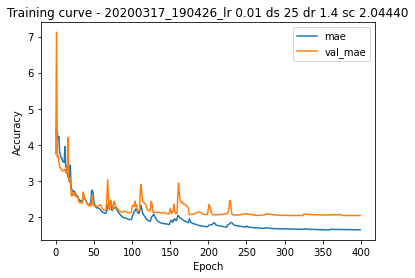

In [22]:
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label = 'val_mae')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.1, 1])
plt.legend(loc='upper right')
sc = history.history['val_mae'][-1]
params = '{}_lr {} ds {} dr {} sc {:.5f}'.format(dt_str, lr, ds, dr, sc)
title = 'Training curve - {}'.format(params)
plt.title(title)
plt.savefig('{}_history.png'.format(dt_str))

test_loss, test_mae, test_mse = model.evaluate(test_X,  normalized_test_y, verbose=2)

display('Test accuracy:', test_loss)

# More upper features.

### Save the model

Saves into keras savemodel file.

In [93]:
model_path = './bs/model_man_224_10k_v3.1.h5'

In [94]:
model.save(model_path)

Call following cell with tensorflow 1.14 to convert keras SaveModel into tensorflow pb model.

In [ ]:
def my_freeze_graph(output_node_names, destination, name="frozen_model.pb"):
    """
    Freeze the current graph alongside its weights (converted to constants) into a protobuf file.
    :param output_node_names: The name of the output node names we are interested in
    :param destination: Destination folder or remote service (eg. gs://)
    :param name: Filename of the saved graph
    :return:
    """
    tf.keras.backend.set_learning_phase(0)  # set inference phase

    sess = tf.keras.backend.get_session()
    input_graph_def = sess.graph.as_graph_def()     # get graph def proto from keras session's graph

    with sess.as_default():
        # Convert variables into constants so they will be stored into the graph def
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            input_graph_def,
            output_node_names=output_node_names)

        tf.train.write_graph(graph_or_graph_def=output_graph_def, logdir=destination, name=name, as_text=False)

    #tf.keras.backend.clear_session()

In [4]:
model = tf.keras.models.load_model(model_path)
print ('Loaded the pre-trained model.')

print(f'input_layer_name={model.input.name}')
output_layer_name = model.output.name.split(':')[0]
print(f'output_layer_name={output_layer_name}')

my_freeze_graph([output_layer_name], destination='./bs', name="model_man_init_gpu.pb")  # <-- Uncomment this

## Evaluate the engine

D:\ProgramData\Anaconda3_standalone\envs\tf2\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


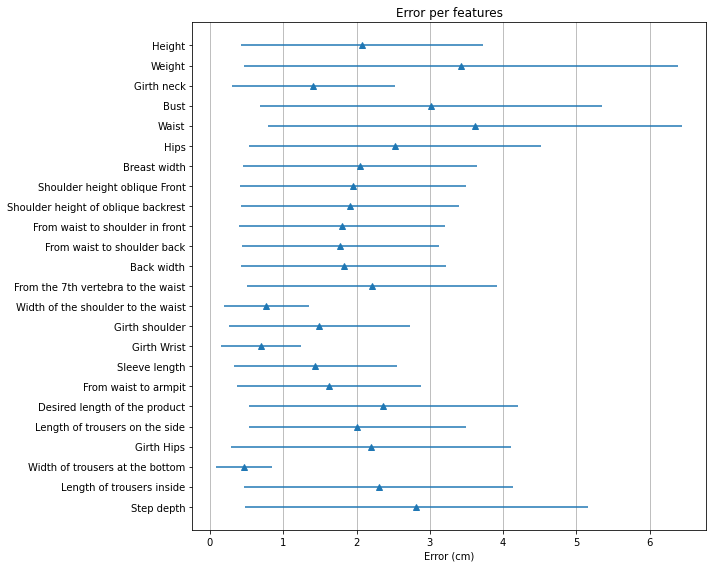

In [147]:
predictions = model.predict(test_X)
if normalize_on:
    predictions = scaler.inverse_transform(predictions)

# Prepare the plot
figure = image_error(predictions)
plt.savefig('{}_loss.png'.format(dt_str))
figure.show()

Some lazy debugging here :(

In [24]:
vals = np.array([np.absolute(test_y[i] - predictions[i]) for i in range(len(test_y))])

def show_feature_err_hist(feature_idx, bins=10):
    display('Stat for feature: [{}]'.format(param_names[1+feature_idx]))
    f_vals = vals[:, feature_idx]
    display(np.mean(f_vals))
    display(np.max(f_vals))
    display(np.histogram(f_vals, bins=bins))

show_feature_err_hist(2, bins=10)

'Stat for feature: [Girth neck]'

1.4292848100560296

7.096981382812501

(array([608, 559, 379, 245, 105,  49,  32,  12,   4,   7], dtype=int64),
 array([0.000633305175782084, 0.710268112939454, 1.419902920703126,
        2.129537728466798, 2.83917253623047, 3.5488073439941417,
        4.258442151757814, 4.968076959521485, 5.677711767285158,
        6.38734657504883, 7.096981382812501], dtype=object))

In [25]:
hm_abs = np.mean(vals, axis=1)
display('error histogram per human', np.histogram(hm_abs, bins=10))

hm_maxs = np.max(vals)
hm_means = np.mean(vals)
hm_stds = np.std(vals)

display('human max', np.mean(np.array(hm_maxs)))
display('human mean', np.mean(np.array(hm_means)))
#display(np.array(errs).reshape((-1,2)).tolist())

'error histogram per human'

(array([171, 823, 629, 261,  86,  21,   3,   5,   0,   1], dtype=int64),
 array([0.7274428438161212, 1.3194953193679808, 1.9115477949198407,
        2.5036002704717, 3.09565274602356, 3.68770522157542,
        4.2797576971272795, 4.8718101726791385, 5.463862648230998,
        6.055915123782858, 6.647967599334717], dtype=object))

'human max'

24.894958260742214

'human mean'

2.021506686768901

In [26]:
cols = 3
test_idx = 0
display('ground-truth', test_y[test_idx].reshape(-1, cols).tolist())
display('prediction', predictions[test_idx].reshape(-1, cols).tolist())
dist = np.absolute(test_y[test_idx] - predictions[test_idx])
display(dist)
display('mean', np.mean(dist))
display('max', np.max(dist))
display('std', np.std(dist))

'ground-truth'

[[188.157227, 132.702637, 48.814655],
 [123.60479, 132.182785, 125.62171200000002],
 [47.750183, 65.05435899999999, 54.557968],
 [62.868427000000004, 54.975964000000005, 49.537521000000005],
 [52.66444, 16.024433, 39.36813],
 [20.449517999999998, 62.448333999999996, 26.318169],
 [106.580421, 106.47163400000001, 71.763588],
 [13.246468, 77.98526, 88.165375]]

'prediction'

[[183.470703125, 135.10159301757812, 47.51319122314453],
 [127.58882141113281, 130.04446411132812, 128.5645294189453],
 [51.18975830078125, 67.23387145996094, 53.06169509887695],
 [62.350765228271484, 52.42081832885742, 46.18589782714844],
 [51.17068099975586, 14.94336223602295, 40.925384521484375],
 [20.581714630126953, 63.691551208496094, 23.828872680664062],
 [108.31167602539062, 106.68010711669922, 76.66845703125],
 [14.157464981079102, 76.21754455566406, 85.72647094726562]]

array([4.686523875000006, 2.398956017578115, 1.3014637768554707,
       3.9840314111328183, 2.1383208886718705, 2.942817418945296,
       3.43957530078125, 2.1795124599609466, 1.4962729011230493,
       0.5176617717285197, 2.555145671142583, 3.3516231728515677,
       1.4937590002441397, 1.0810707639770492, 1.5572545214843743,
       0.13219663012695548, 1.2432172084960982, 2.4892963193359385,
       1.7312550253906238, 0.20847311669920998, 4.904869031250001,
       0.9109969810791014, 1.7677154443359342, 2.4389040527343724],
      dtype=object)

'mean'

2.122954698371887

'max'

4.904869031250001

'std'

1.2547740822047264

In [ ]:
# sess.close()

## Real environment validation

Test the engine with the depth images captured from real human.

In [27]:
validation_files = find('*.png', './dataset/validate/')

print('Number of test images: ', len(validation_files))

Number of test images:  20


In [48]:
img_count = 0
validation_input_ds = np.array([load_img(file, n_channels=1) for file in validation_files])
display('dimension of validation_input_ds', validation_input_ds.shape)

'dimension of validation_input_ds'

(20, 512, 512, 1)

In [58]:
def load_validation_image(index):
    display(np.histogram(validation_input_ds[index], bins=10))
    test_val_X = validation_input_ds[index]
    #test_val_X[test_val_X_1<0.4] = 0
    #test_val_X_1[test_val_X_1>0.7] = 0
    #display(np.histogram(test_val_X_1, bins=10))
    plt.imshow(test_val_X[:,:,0].astype(dtype=np.float32), cmap=plt.cm.binary)
    return test_val_X

In [85]:
def show_result(test_val_X):
    predictions = model.predict(test_val_X.reshape((-1,512,512,1)))
    normalize_on = False
    if normalize_on:
        predictions = scaler.inverse_transform(predictions)

    display(predictions)
    
    vals = predictions[0]

    fig, ax = plt.subplots(figsize=(10,8))
    #ax.bar(feature_means, range(n_features,0,-1), xerr=feature_stds, align='center', alpha=0.5, ecolor='black', capsize=10)
    y_pos = np.arange(len(vals))
    rects = plt.barh(y_pos, vals, align='center', linestyle='None')
    ax.set_xlabel('Result (cm)')
    ax.set_yticks(x_pos)
    ax.set_yticklabels(param_names[1:])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Features')
    ax.set_title('Result')
    ax.xaxis.grid(True)
    
    
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{:.1f}'.format(width),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='left', va='center')

    # Save the figure and show
    plt.tight_layout()
    fig.show()
    

(array([246760,      0,      0,      0,      0,      0,      0,   7690,
          7658,     36], dtype=int64),
 array([0.    , 0.0707, 0.1414, 0.2119, 0.2827, 0.3533, 0.4238, 0.4946,
        0.5654, 0.6357, 0.7065], dtype=float16))

array([[172.53616 ,  81.79983 ,  41.562763,  99.71463 ,  93.158806,
        103.75624 ,  43.323265,  57.084885,  48.91805 ,  54.158016,
         50.009045,  39.946346,  48.559864,  13.827819,  32.95308 ,
         17.661118,  58.360786,  24.554863,  98.846725,  99.017365,
         62.28157 ,  12.081706,  71.42998 ,  71.0195  ]], dtype=float32)

D:\ProgramData\Anaconda3_standalone\envs\tf2\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


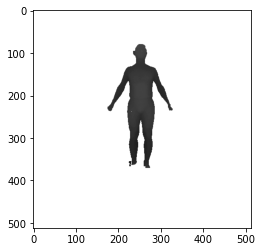

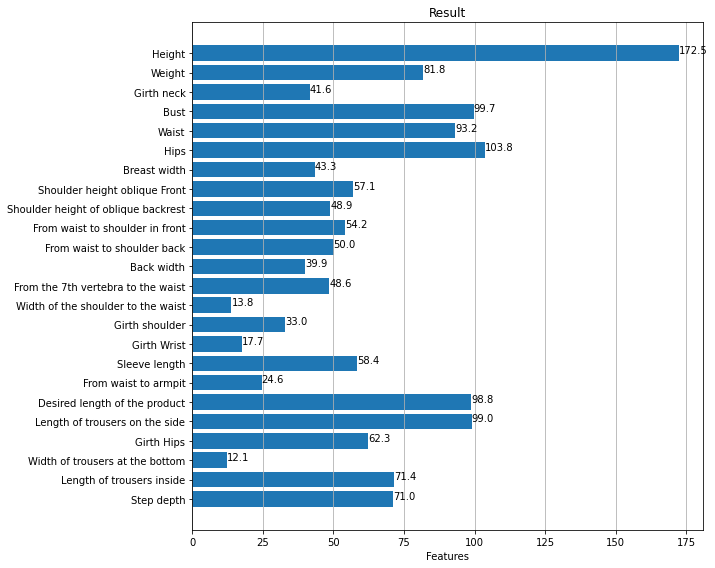

In [98]:
test_val_X = load_validation_image(8)

show_result(test_val_X)

(array([249295,      1,      0,      0,      0,      0,      0,     30,
          1619,  11199], dtype=int64),
 array([0.    , 0.0719, 0.1438, 0.2156, 0.2876, 0.3594, 0.4312, 0.503 ,
        0.575 , 0.647 , 0.7188], dtype=float16))

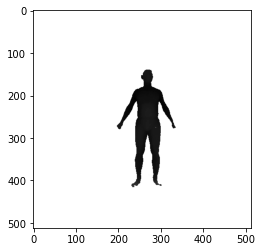

In [62]:
test_val_X_2 = load_validation_image(4)

In [55]:
def convert_to_millimeter(val):
    return val * (max_depth - min_depth) + min_depth

d1 = 0.7
d2 = 0.4866
test_val_X = test_val_X_2

distance = convert_to_millimeter(d1)
display('distance', distance)

#display()
val_sums = np.sum(test_val_X[:,:,0], axis=1)

height_pixels = len(val_sums)
min_index = 0
max_index = height_pixels
for i in range(height_pixels):
    if val_sums[i] == 0 and min_index == i - 1:
        min_index = i
    inv_i = len(val_sums)-i-1
    if val_sums[inv_i] == 0 and max_index == inv_i + 1:
        max_index = inv_i
display('top', min_index, 'bottom', max_index)

height = max_index - min_index

import math
# convert the height to distance
display('height', math.tan(70*3.1415927/180.0/2.0) * distance * 2 * height / height_pixels)

'distance'

2390.0

'top'

139

'bottom'

416

'height'

1810.7750211891052